# Homework 2 Solutions
Modules that we'll use for our solutions.

In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.linalg import solve
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Use LaTex
plt.rcParams['text.usetex'] = True

# Use Seaborn style
plt.style.use('seaborn')
#plt.style.use('seaborn-v0_8')

## Question 1
The matrix
$$
P = \left(\begin{array}{c c c c} 0.84 & 0.13 & 0.03 &  0\\ 0.10 &  0.77 & 0.09 & 0.04\\ 0.10 &  0.20 &  0.65 &  0.05\\ 0 &  0 &  0 & 1\end{array}\right)
$$
denotes the one-year transition probabilities for firms with investment grade, speculative, junk, and defaulted unsecured debt. The rows represent the current states, and the columns represent the states after one year. For example, the probability that a firm with investment grade debt transitions to a firm whose debt is considered junk after one year is 3\%, while the probability that a firm whose debt is considered junk transitions to a firm with speculative debt is 20\%. Notice that we are supposing firms do not transition out of default.


(a) Compute $P^2$. Interpret your results. Are there any assumptions attached to your conclusion?


In [3]:
# Define P
P = np.array([[0.84, 0.13, 0.03, 0], [0.10, 0.77, 0.09, 0.04], 
              [0.10, 0.20, 0.65, 0.05], [0, 0, 0, 1]])

# Compute P^2
P_squared = P @ P

print('The matrix P^2 is:\n')
print(np.round(P_squared, 3))

The matrix P^2 is:

[[0.722 0.215 0.056 0.007]
 [0.17  0.624 0.131 0.075]
 [0.169 0.297 0.444 0.09 ]
 [0.    0.    0.    1.   ]]


The matrix $P^2$ denotes the two-year transition matrix. However, we're making the assumption that there is no "path dependence", i.e. what happens in year two has nothing to do with year one beyond the credit profile at the end of year one.

(b) Find the eigenvalues and eigenvectors of $P$.

In [6]:
# Get the eigenvalues and eigenvectors
evals, evecs = np.linalg.eig(P)

# Call evecs N to be consistant with work in class
N = evecs

# Print eigenvalues and corresponding eigen vectors
for eval, evec in zip(evals, evecs.T):
    
    print(f'Eigenvalue {eval:.3f} with corresponding eigenvector {np.round(evec, 3)}^T.')

Eigenvalue 0.975 with corresponding eigenvector [0.644 0.548 0.534 0.   ]^T.
Eigenvalue 0.721 with corresponding eigenvector [ 0.697 -0.523 -0.491  0.   ]^T.
Eigenvalue 0.563 with corresponding eigenvector [ 0.111 -0.441  0.89   0.   ]^T.
Eigenvalue 1.000 with corresponding eigenvector [0.5 0.5 0.5 0.5]^T.


(c) Use (b) to diagonalize $P$.

In [8]:
# Calculate the diagonal matrix
D = np.linalg.inv(N) @ P @ N

# Print D with a little explanation
print('The diagonal matrix D is: \n')
  
print(np.round(D, 3))

The diagonal matrix D is: 

[[ 0.975 -0.     0.     0.   ]
 [-0.     0.721 -0.    -0.   ]
 [-0.     0.     0.563 -0.   ]
 [ 0.     0.     0.     1.   ]]


In [9]:
# Verify that everything is in-line with the theory
is_close = np.sum(np.isclose(D, np.diag(evals)))

# Print check
print(f'The value of is_close should equal {P.shape[0]**2} if everything is correct.')
print(f'is_close = {is_close}') 

The value of is_close should equal 16 if everything is correct.
is_close = 16


(d) Analytically compute $\displaystyle\lim_{n\to\infty} P^n$ using (c). 

From lecture we know $P^n = N D^n N^{-1}$, where the columns of $N$ are our basis of eigenvectors. Hence,
$$
P^n \approx N \left(\begin{array}{c c c c} \lambda_1^n & 0 & 0 & 0\\ 0 & \lambda_2^n & 0 & 0\\ 0 & 0 & \lambda_3^n & 0 \\ 0 & 0 & 0 & \lambda_4^2\end{array}\right) N^{-1},
$$
where $0 < \lambda_k < 1$ for $k = 1, 2,$ or 3, and $\lambda_4 = 1$. Hence, it is clear
$$
\lim_{n\to\infty} P^n = N \left(\begin{array}{c c c c} 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1\end{array}\right) N^{-1} = \left(\begin{array}{c c c c} 0 & 0 & 0 & 1\\0 & 0 & 0 & 1\\0 & 0 & 0 & 1\\ 0 & 0 & 0 & 1\end{array}\right).
$$
We will check the result below.

In [10]:
# Raise D to a large integer to check
approx_answer = N @ D**1000 @ np.linalg.inv(N)

# Analytic answer
analytic_answer = np.array([[0, 0, 0, 1], [0, 0, 0, 1], 
                            [0, 0, 0, 1], [0, 0, 0, 1]])

# Count the number of entries that line up
is_close = np.sum(np.isclose(approx_answer, analytic_answer))

# Print check
print(f'The value of is_close should equal {P.shape[0]**2} if everything is correct.')
print(f'is_close = {is_close}') 

The value of is_close should equal 16 if everything is correct.
is_close = 16


## Question 2
You have graduated from the MFE program and landed yourself a job as a quantitative trading analyst in a pod shop! Through careful analysis, you determine that the best way to model the market impact of trades is via a function proportional to $x^{3/2}$, where $x$ represents the size of the transaction as a percent. However, your shop uses quadratic programming for portfolio construction. Hence, to integrate a market impact model into the quadratic program, the model must be a quadratic polynomial. As a result, your goal is to approximate $x^{3/2}$ using a quadratic polynomial. Your pod shop does not make any trades larger than 1\% of its portfolio as a matter of policy. Therefore, if $\hat{f}$ is your approximation, you are interested in reducing the error
$$
\int_0^1 \left[x^{3/2} - \hat{f}(x)\right]^2\ dx.
$$

You want to find the orthogonal projection of $x^{3/2}$ onto the subspace of quadratic polynomials.  Since you are interested in reducing the square error, use the inner product
$$
\langle f, g\rangle = \int_0^1 f(x) g(x)\ dx.
$$


In [24]:
# Define inner product based on question
inner_product = lambda f, g: quad(lambda x: f(x) * g(x), 0, 1)[0]

# Use inner product to create norm
norm = lambda f: np.sqrt(inner_product(f, f))

# Define market impact function
market_impact_fun = lambda x: x**(3/2)

# Create function to get polynomial coefficients
def get_plolynomial_coeffs(plolynomial, degree):
        
    # Generate test x-values
    test_vals = np.arange(1, degree + 2).reshape((-1, 1))

    # Raise test_vals to powers up to degree
    A = np.concatenate([test_vals**i for i in range(degree + 1)], axis = 1)

    # Evaluate at test_vals; assume plolynomial vectorized
    y = plolynomial(test_vals)

    # Solve system
    coeffs = solve(A, y).flatten()

    # Usually polynomials written from highest to lowest degree
    coeffs = np.flip(coeffs)

    return coeffs
       

(a) Orthogonalize the basis $(1, x, x^2)$.

In [26]:
# Use Gram-Schmidt process to find u_i
u0 = lambda x: 1
u1 = lambda x: x - inner_product(lambda x: x, u0)/norm(u0)**2 * u0(x)
u2 = lambda x: (x**2 - inner_product(lambda x: x**2, u1)/norm(u1)**2 * u1(x)
                - inner_product(lambda x: x**2, u0)/norm(u0)**2 * u0(x))

print('The orthogonal basis is:\n ')

# Let's find algebraic expressions for u_i

# u_0 is the simplest since it's constant
print(f'u_0(x) = {u0(0)}')

# Use function to find coeffs of u1
coeffs1 = get_plolynomial_coeffs(u1, 1)

# Print results
print(f'u_1(x) = {coeffs1[0]:.3f} x + {coeffs1[1]:.3f}')

# Use function to find coeffs of u2
coeffs2 = get_plolynomial_coeffs(u2, 2)

print(f'u_2(x) = {coeffs2[0]:.3f} x^2 + {coeffs2[1]:.3f} x + {coeffs2[2]:.3f}')


The orthogonal basis is:
 
u_0(x) = 1
u_1(x) = 1.000 x + -0.500
u_2(x) = 1.000 x^2 + -1.000 x + 0.167


(b) Use your result from (a) to project $x^{3/2}$ onto the subspace of polynomials of order at most two.

In [21]:
# Initialize array to hold coefficients
alphas = np.zeros(3)

# Calculate coefficients of projection of market_impact_fun onto each u_i
for i, u in enumerate([u0, u1, u2]):
    
    alphas[i] = inner_product(market_impact_fun, u)/norm(u)**2

# Get projection function
proj = lambda x: alphas[0] * u0(x) + alphas[1] * u1(x) + alphas[2] * u2(x)

# Find coefficients of projection function
coeffs_proj = get_plolynomial_coeffs(proj, 2)

print('The market impact function projected onto the subspace of quadratic polynomials is:\n')
print(f'{coeffs_proj[0]:.3f} x^2 + {coeffs_proj[1]:.3f} x + {coeffs_proj[2]:.3f}')

The market impact function projected onto the subspace of quadratic polynomials is:

0.571 x^2 + 0.457 x + -0.019


(c) To access model efficacy, also use a second-degree Taylor polynomial centered at $x = 1/2$ to approximate $x^{3/2}$.

In [27]:
# Define small step
h = 1e-4

# Calculate the zero-th, first, and second derivatives evaluated at x = 1/2
a = market_impact_fun(1/2)
b = (market_impact_fun(1/2 + h) - market_impact_fun(1/2 - h))/(2 * h)
c = (market_impact_fun(1/2 + h) - 2 * market_impact_fun(1/2) + market_impact_fun(1/2 - h))/h**2

# Use results to obtain second-degree Taylor polynomial
taylor = lambda x: a + b * (x - 1/2) + c/2 * (x - 1/2)**2

# Find coefficients of Taylor polynomial
coeffs_taylor = get_plolynomial_coeffs(taylor, 2)

print('The second-degree Taylor polynomal approximation of the market impact function is:\n')
print(f'{coeffs_taylor[0]:.3f} x^2 + {coeffs_taylor[1]:.3f} x + {coeffs_taylor[2]:.3f}')

The second-degree Taylor polynomal approximation of the market impact function is:

0.530 x^2 + 0.530 x + -0.044


(d) Graph  $x^{3/2}$ as well as your results from (b) and (c) on one plot via $\texttt{plot}$ in $\texttt{matplotlib.pyplot}$. Make sure to add a legend.

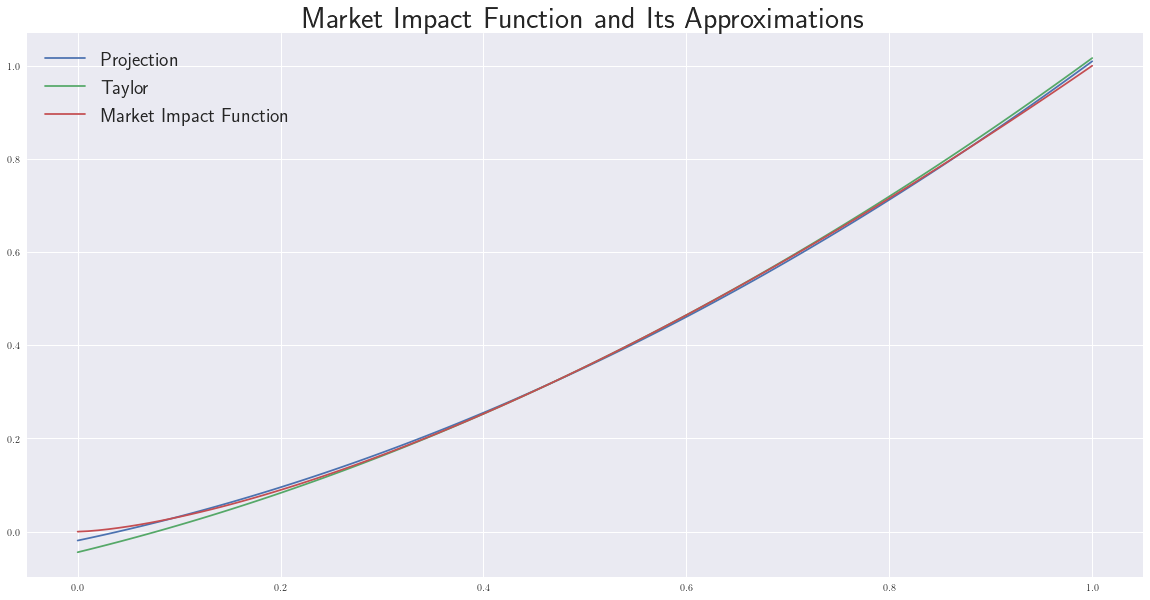

In [30]:
# Define x-values for plot
x_vals = np.linspace(0, 1, 100)

# Make figure a bit bigger
plt.figure(figsize = (20, 10))

# Plot projection
plt.plot(x_vals, proj(x_vals), label = r'Projection')

# Plot Taylor series
plt.plot(x_vals, taylor(x_vals), label = r'Taylor')

# Plot market impact model
plt.plot(x_vals, market_impact_fun(x_vals), label = 'Market Impact Function')

plt.title('Market Impact Function and Its Approximations', fontsize = 30)
plt.legend(fontsize = 20)

plt.show()


(e) Compute the norm between $x^{3/2}$ and your results from (b) and (c).

In [23]:
# Calculate norm between x^(3/2) and projection
error_projection = norm(lambda x: market_impact_fun(x) - proj(x))

# Calculate norm between x^(3/2) and Taylor series
error_taylor = norm(lambda x: market_impact_fun(x) - taylor(x))


print(f'The norm between the projection and x^(3/2) is {error_projection:.3f}')
print(f'The norm between the Taylor series and x^(3/2) is {error_taylor:.3f}')

The norm between the projection and x^(3/2) is 0.005
The norm between the Taylor series and x^(3/2) is 0.011


## Question 3

| $x_i$ | -1 | 0 | 1 | 2 | 3 |
| --- | --- | --- | --- | --- | --- |
| $y_i$ |3.02 | 2.18 | 4.08 | -0.03| -1.08|

Consider the function $f$ whose $xy$-coordinates are in the table above. We want to approximate $f$ via a function of the form $\alpha + \beta x$. 

(a)  Define
$$
\mathcal{L}_2(\alpha, \beta) = \sum_{i = 1}^5 \left(y_i- \alpha - \beta x_i\right)^2.
$$
Analytically minimize $\mathcal{L}_2$ with respect to $\alpha$ and $\beta$ to find the optimal coefficients. Remember to check whether your solution is a minimum or a maximum. Since $\mathcal{L}_2$ is convex a local minimum is a global minimum. 

**Solution** We need to take the parials of $\mathcal{L}_2$ with respect to $\alpha$ and $\beta$:
$$
\frac{\partial \mathcal{L}_2}{\partial \alpha} = -2 \sum_{i = 1}^5 (y_i - \alpha - \beta x_i) = -16.34 + 10 \alpha +10\beta,
$$
and
$$
\frac{\partial \mathcal{L}_2}{\partial \beta} = -2 \sum_{i = 1}^5 x_i (y_i - \alpha - \beta x_i) = 4.28 +10\alpha + 30\beta.
$$
Note: we used Python to calculate
$$
\sum_{i = 1}^5 y_i = 8.17\qquad\text{and}\qquad \sum_{i = 1}^5 x_i y_i = -2.24.
$$
as well as
$$
\sum_{i = 1}^5 x_i = 5\qquad\text{and}\qquad \sum_{i = 1}^5 x_i^2 = 15
$$
though the latter two could have been calculated easily with formulas. Hence, the critical numbers are the solutions of
$$
\begin{align*}
10 \alpha +10 \beta &= 16.34\\
10\alpha + 30\beta &= -4.28.
\end{align*}
$$
Solving this system yields
$$
\alpha = 2.675\qquad\text{and}\qquad \beta = -1.041.
$$

To verify that this is a minimum, we first find the local minima. To find the local minima, we will use the second derivatives test. We need to find
$$
D = \left|\begin{array}{c c} \frac{\partial^2 \mathcal{L}_2}{\partial \alpha^2} & \frac{\partial^2 \mathcal{L}_2}{\partial \alpha\partial\beta}\\
\frac{\partial^2 \mathcal{L}_2}{\partial \beta\partial\alpha} & \frac{\partial^2 \mathcal{L}_2}{\partial \beta^2}\end{array}\right|.
$$
In this case,
$$
\frac{\partial^2 \mathcal{L}_2}{\partial \alpha^2} = 10,\qquad \frac{\partial^2 \mathcal{L}_2}{\partial \alpha\partial\beta}=
 \frac{\partial^2 \mathcal{L}_2}{\partial \beta \partial\alpha} = 10,\qquad \frac{\partial^2 \mathcal{L}_2}{\partial \beta^2} = 30. $$
Hence,
$$
D = \left|\begin{array}{c c} 10 & 10\\ 10 & 30\end{array}\right| = 300 - 100 = 200.
$$
Because
$$
\frac{\partial^2 \mathcal{L}_2}{\partial \alpha^2} = 10 > 0\qquad\text{and}\qquad D = 200 > 0,
$$
we conclude that our solution is a local minimum. Because $\mathcal{L}_2$ is convex, local minima are global minima.

(b) Use $\texttt{minimize}$ in $\texttt{scipy.optimize}$ to check your result from (a).

In [36]:
# Type in x- and y-values
x_vals = np.array([-1, 0, 1, 2, 3])
y_vals = np.array([3.02, 2.18, 4.08, -0.03, -1.08])

# Define objective function
def L2(alpha):
    
    # Calculate approximation
    y_hat = alpha[0] + alpha[1] * x_vals
    
    # Calculate sum of squared error
    error = np.sum((y_vals - y_hat)**2)
    
    return error

# Minimize objective function
res2 = minimize(L2, x0 = [0, 0])

# Save coefficients
alpha2 = res2.x

# Print results
res2

      fun: 7.499910000000002
 hess_inv: array([[ 0.15, -0.05],
       [-0.05,  0.05]])
      jac: array([1.1920929e-07, 1.1920929e-07])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([ 2.67500002, -1.04100001])

(c) Your results in (a) and (b) minimized the square error, which is highly sensitive to outliers. Another approach is to minimize the absolute error. Use $\texttt{minimize}$ to find $\alpha$ and $\beta$ that minimize
$$
\mathcal{L}_1(\alpha, \beta) = \sum_{i = 1}^5 \left| y_i- \alpha - \beta x_i\right|.
$$
Because $\mathcal{L}_1$ is hard to optimize, the optimizer may fail to converge. As long as your coefficients are reasonable, your solution is acceptable. 


In [37]:
# Define objective function
def L1(alpha):
    
    # Calculate approximation
    y_hat = alpha[0] + alpha[1] * x_vals
    
    # Calculate sum of absolute errors
    error = np.sum(np.abs(y_vals - y_hat))
    
    return error

# Minimize objective function; use method that doesn't require derivatives
res1 = minimize(L1, x0 = [0, 0], method = 'Nelder-Mead')

# Save coefficients
alpha1 = res1.x

# Print results
res1

 final_simplex: (array([[ 2.11949869, -1.06649956],
       [ 2.11959226, -1.06653075],
       [ 2.11946029, -1.06648676]]), array([3.27, 3.27, 3.27]))
           fun: 3.2700000000001395
       message: 'Optimization terminated successfully.'
          nfev: 193
           nit: 105
        status: 0
       success: True
             x: array([ 2.11949869, -1.06649956])

(d) Use $\texttt{scatter}$ to graph the points in the table. Also, use $\texttt{plot}$ to graph the lines corresponding to the coefficients you found in (a) and (c) on the same figure. Make sure to add a legend so that it is easy to interpret your results.


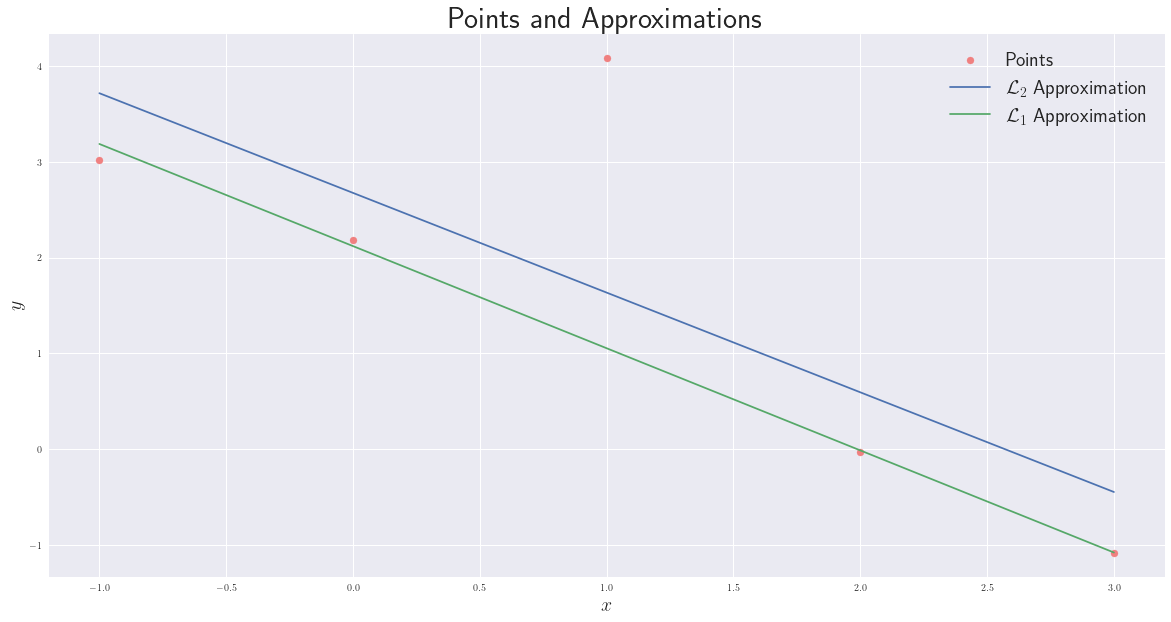

In [38]:
# Change figure dimensions
plt.figure(figsize = (20, 10))

# Plot original points
plt.scatter(x_vals, y_vals, label = 'Points', color = 'lightcoral')

# Plot the values for the L_2 approximation
plt.plot(x_vals, alpha2[0] + alpha2[1] * x_vals, label = r'$\mathcal{L}_2$ Approximation')

# Plot the values for the L_1 approximation
plt.plot(x_vals, alpha1[0] + alpha1[1] * x_vals, label = r'$\mathcal{L}_1$ Approximation')

# Add a legend
plt.legend(fontsize = 20)

# Add x label to axis
plt.xlabel(r'$x$', fontsize = 20)

# Add y label to axis
plt.ylabel(r'$y$', fontsize = 20)

# Give the graph a title
plt.title(r'Points and Approximations', fontsize = 30)

plt.show()

## Question 3
A convertible bond is a debt instrument that gives	the owner the right, but not the obligation, to convert their debt into a predetermined number of shares of common stock. For this problem, we will suppose that the owner has the right to convert their convertible bond to one share of common stock. 

Supposing the underlying stock does not pay dividends, the owner may only convert their shares to common stock at maturity, and the time until maturity is a multiple of 0.5, then--under the Black-Scholes assumptions--the value of the convertible bond is
$$
P = S \Phi(d_1) - 100 e^{-rT} \Phi(d_2) + 100 e^{-rT} + \sum_{k = 1}^{2T} \frac{c}{2} e^{-r k/2},
$$		
where $S$ is the value of common stock, $c$ is the coupon rate paid semiannually, $r$ is the continuously compounded discount rate, $T$ is the time until maturity, $\sigma$ is the volatility of returns of the underlying common stock,
$$
d_1 = \frac{\ln\left(\frac{S}{100}\right) + \left(r + \frac{\sigma^2}{2}\right) T}{\sigma\sqrt{T}}\qquad\text{and}\qquad d_2 = d_1 - \sigma\sqrt{T}.
$$		
The function $\Phi$ is the standard normal cdf, which can be accessed in Python via $\texttt{norm.cdf}$ within $\texttt{scipy.stats}$.

(a) Write a Python function that gives $P$ as a function of $c$, $r$, $S$, $T$, and $\sigma$. Evaluate it when $c = 5\%$, $r = 10\%$, $S = 60$, $T = 5$, and $\sigma = 40\%$. Make sure that $r$ and $\sigma$ are written in decimal form when using the pricing formula. You do not need to convert $c$ to a decimal. 

In [31]:
# We need the normal cdf
from scipy.stats import norm as gauss

# Define variables so we don't have to keep typing them
c, r, S, T, sigma = 5, 0.08, 65, 5, 0.35

# Define pricing function
def get_cvt(c, r, S, T, sigma):
    
    # Define d_1 and d_2
    d1 = (np.log(S/100) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calculate value of call option
    call = S * gauss.cdf(d1) - 100 * np.exp(-r * T) * gauss.cdf(d2)
    
    # Get the value of the bond
    bond = 100 * np.exp(-r * T) + c/2 * np.sum(np.exp(-r * np.arange(T, 0, -0.5)))
    
    return call + bond

# Calculate the price
P = get_cvt(c = c, r = r, S = S, T = T, sigma = sigma)

print(f'The price of the convertible is {P:.2f}.')

The price of the convertible is 106.32.


(b) Use your function in part (a) to compute the numerical partial derivatives of $P$	with respect to $S$ and $r$. As before, evaluate it when $c = 5\%$, $r = 8\%$, $S = 65$, $T = 5$, and $\sigma = 35\%$.

In [39]:
# Define our small step
h = 1e-4

# Compute the partial derivatives
P_S = (get_cvt(c = c, r = r, S = S + h, T = T, sigma = sigma) 
       - get_cvt(c = c, r = r, S = S - h, T = T, sigma = sigma))/(2 * h)

P_r = (get_cvt(c = c, r = r + h, S = S, T = T, sigma = sigma) 
       - get_cvt(c = c, r = r - h, S = S, T = T, sigma = sigma))/(2 * h)

print(f'The respective partial derivatives of S and r are {P_S:.2f} and {P_r:.2f}.')

The respective partial derivatives of S and r are 0.64 and -275.64.


(c) Unlike options where we normally suppose there is no credit risk, the discount rate $r$ for a convertible bond reflects the credit of the corresponding firm. Credit risk is closely related to the stock price. Because of this, when the stock price goes up, $r$ goes down because it is easier for the firm to raise capital. In contrast, when the stock price goes down, $r$ goes up. After careful analysis, you discover that if the stock goes from $S_0$ to $S_1$, the discount rate goes from $r_0$ to 
$$
r_1 \approx \left(\frac{S_0}{S_1}\right)^{0.15} r_0.
$$
Write a Python function that returns $r_1$ given $S_0$, $S_1$ and $r_0$.

In [40]:
# Write function to get new r
get_r = lambda r0, S0, S1: (S0/S1)**0.15 * r0

(d) Compute the numerical partial derivative of your function in (c) with respect to $S_1$. Suppose $S_0 = S_1 = 65$ and $r_0 = 8\%$.

In [41]:
# Get numerical partial derivative of r with respect to S
r_S = (get_r(r, S, S + h) - get_r(r, S, S - h))/(2 * h)

print(f'The partial derivatives is {r_S:.5f}.')

The partial derivatives is -0.00018.


(e) In part (b), you computed the partial derivative of the convertible bond with respect to $S$. However, as mentioned previously, when the equity changes we also expect the discount rate to change. Use your results from (b) and (d) to find the total derivative of the convertible bond price with respect to the value of the underlying equity. In this case, the total derivative is
$$
\frac{d P}{d S} = \frac{\partial P}{\partial S} + \frac{\partial P}{\partial r}\frac{\partial r}{\partial S}.
$$
Note: we are ignoring the effect of a change in $\sigma$ due to a change in the stock price.

In [35]:
# Get total derivative
total = P_S + P_r * r_S

print(f'The total derivatives is {total:.3f}.')

The total derivatives is 0.688.
